In [1]:
from sympy import init_printing
init_printing()

# The 'Andoyer' model for Resonance
The 'Andoyer' class of Hamiltonians provide models for $k$th-order mean motion resonance (e.g. Henrard and Lemaitre (1983), Ferraz-Mello (2007)). After a long slog of canoncial tranformations, one can show that the resonant dynamics of a pair of planets is governed by a Hamiltonian of the form:
\begin{equation}
H_{k}(\Phi,\phi;\alpha) = 4\Phi^2-3\alpha\Phi +(\sqrt{2\Phi})^{k/2}\cos\phi 
\end{equation}
where 
\begin{eqnarray}
\Phi&\propto& \Delta a /a_\text{res.} \\
\phi&=&j\lambda_{out} - (j-k)\lambda_{in} - k\varpi\\
\alpha &\propto& <e^2>
\end{eqnarray}.
 These models offer the simplicity of a one-parameter Hamiltonian with a single degree of freedom. However, translating these models to and from orbital elements can be tedious. Luckily, celmech can do it for you!

In [2]:
from celmech import Andoyer, AndoyerHamiltonian

The code below sets up an interactive interface for integrating 'Andoyer' models

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

def wrap(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val

npwrap = np.vectorize(wrap)

class Clicker(object):
    def __init__(self,j,k, Zstar, projection=None):
        self.ax = plt.subplot('111', projection=projection)
        self.j = j
        self.k = k
        self.Zstar = Zstar
        self.projection = projection
        self.cid = self.ax.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        phi = event.xdata
        Z = event.ydata
        if Z < 0:
            return
        andvars = Andoyer.from_Z(self.j,self.k,Z,phi,Zstar)
        self.andvars=andvars
        H = AndoyerHamiltonian(andvars)
        tmax=100*andvars.params['tau']
        Nout = 1000
        times = np.linspace(0, tmax, Nout)
        
        Z, phi = np.zeros(Nout), np.zeros(Nout)
        for i, time in enumerate(times):
            H.integrate(time)
            Z[i] = H.state.Z
            phi[i] = H.state.phi
        if self.projection is None:
            self.ax.plot(npwrap(phi), Z, 'r.')       
        else:
            self.ax.plot(phi, Z, 'r.')

# Click to simulate a simple resonance model

<IPython.core.display.Javascript object>


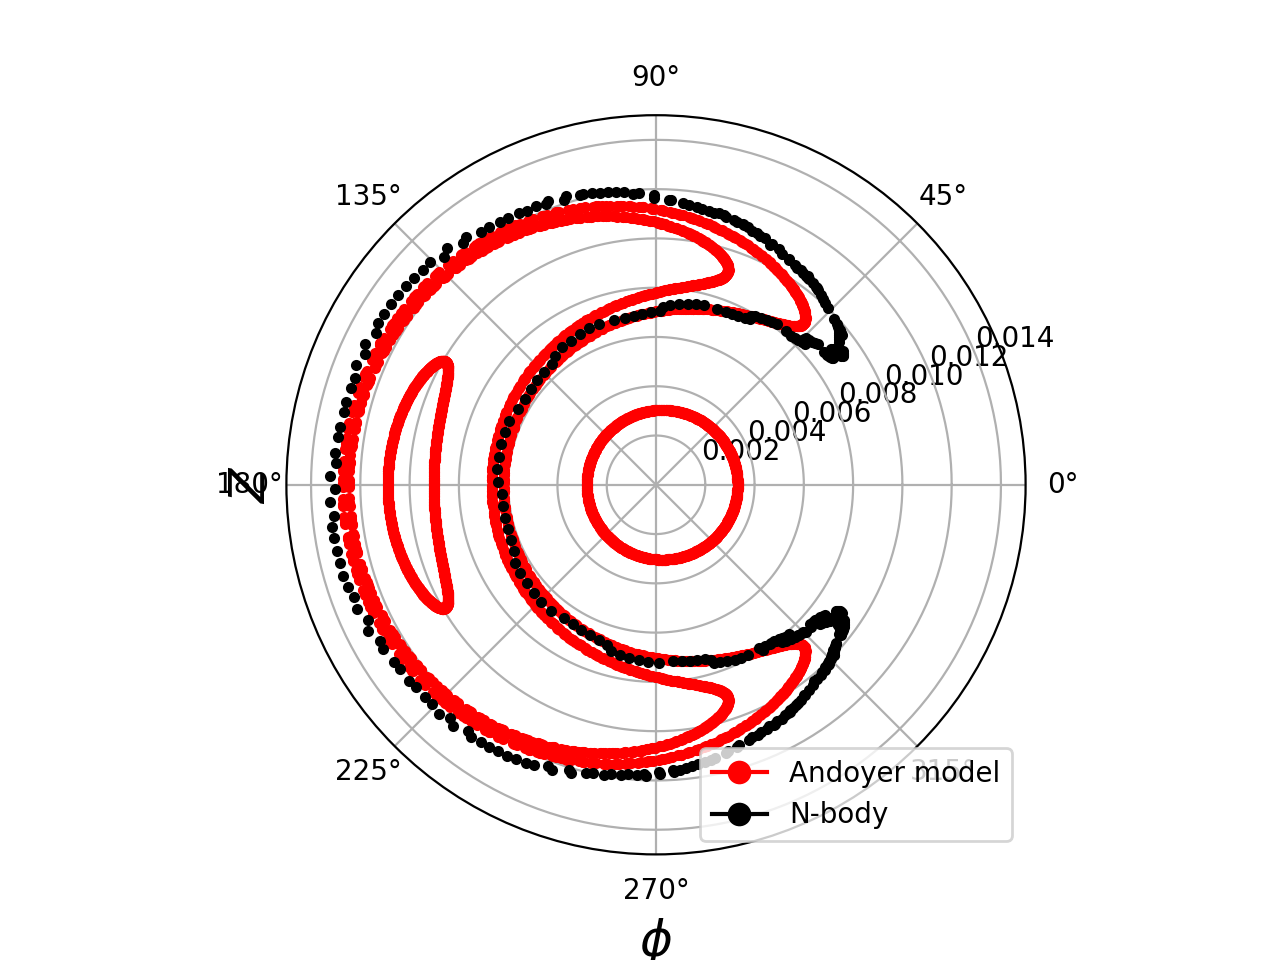

In [4]:
resonance,res_order = 5,2
Zstar = 0.01
clicker=Clicker(resonance,res_order,Zstar,'polar') 
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='Andoyer model')
black_line = mlines.Line2D([], [], color='black', marker='.',
                          markersize=15, label='N-body')
plt.legend(handles=[red_line,black_line])

plt.show()

clicker.ax.set_xlim(0,2*np.pi)
clicker.ax.set_ylim(0,1.5*Zstar)
clicker.ax.set_xlabel('$\phi$',fontsize=18)
clicker.ax.set_ylabel('$Z$',fontsize=18)

# Use canonical transformations to generate N-body integrations!


Initialize N-body integrations directly from  ($\Phi,\phi$) phase space

Run integrations and transform them back

Works for 1st, 2nd and 3rd order resonances.

Applies for general 2-planet system (i.e., no restriction to circular/test-particle case!)

## Run an N-body integration initialzed from the last trajectory clicked

0.005365940122403973 0.005972660481899851


<IPython.core.display.Javascript object>


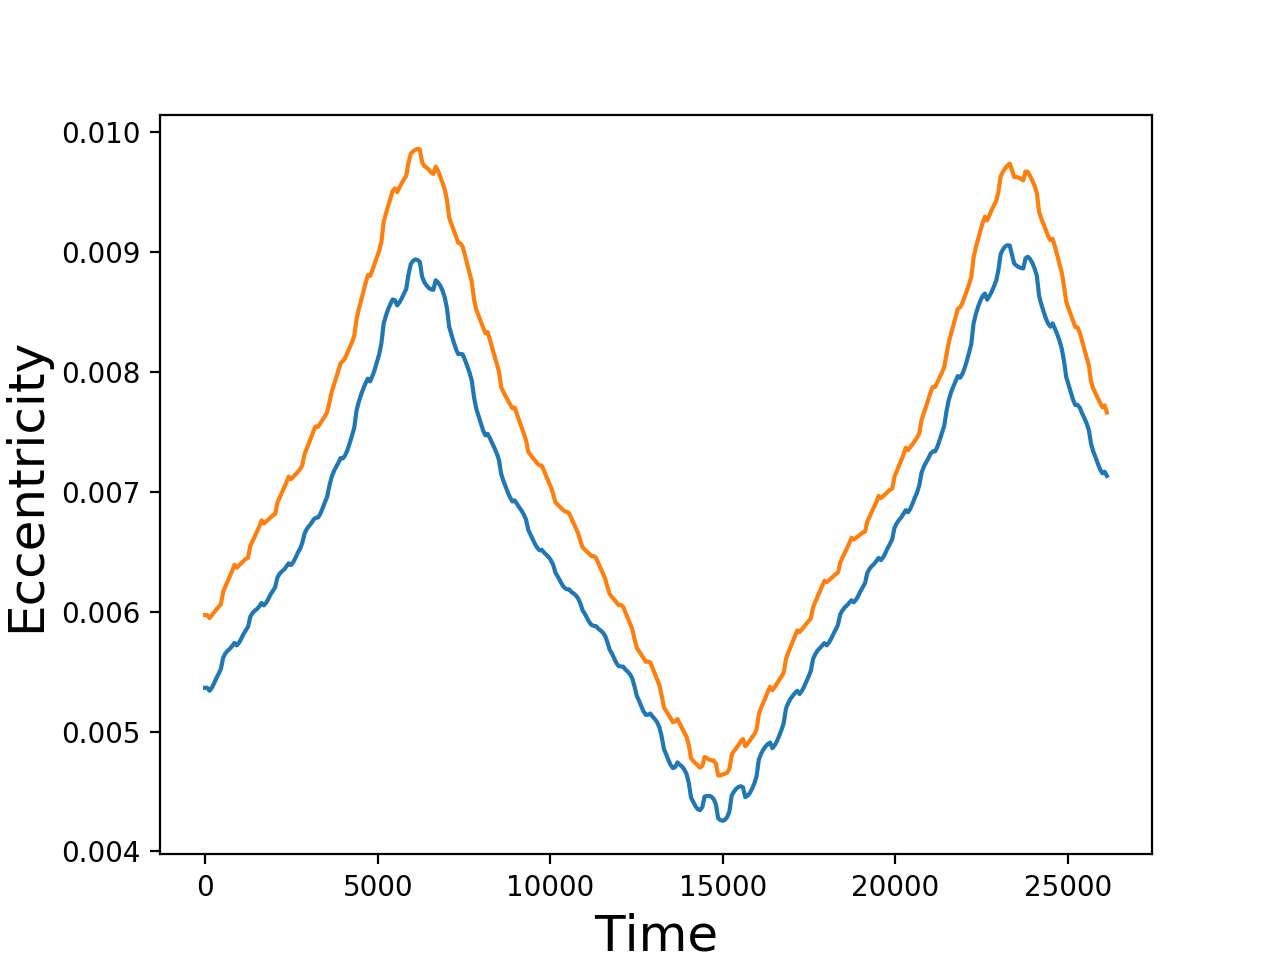

In [5]:
sim=clicker.andvars.to_Simulation();
print(sim.particles[1].e, sim.particles[2].e)
tFin,Nout = 1 * abs(clicker.andvars.params['tau'])*3 , 400
times = np.linspace(0,tFin,Nout)
NZ,Nphi=np.zeros((2,Nout))
orbits=np.zeros((2,4,Nout))
for i,t in enumerate(times):
    NZ[i] = Andoyer.from_Simulation(sim,resonance,res_order).Z
    Nphi[i] = Andoyer.from_Simulation(sim,resonance,res_order).phi
    orbs=sim.calculate_orbits()
    orbits[0,:,i] = orbs[0].a,orbs[0].e,orbs[0].l,orbs[0].pomega
    orbits[1,:,i] = orbs[1].a,orbs[1].e,orbs[1].l,orbs[1].pomega
    sim.integrate(t)

clicker.ax.plot(npwrap(Nphi),NZ,'k.')
fig,ax = plt.subplots(1)
ax.plot(times,orbits[0,1],label='Planet 1')
ax.plot(times,orbits[1,1],label='Planet 2')
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('Eccentricity',fontsize=18)